In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### ZAJĘCIA 8.11.2025

Liczba obrazów w zbiorze treningowym: 60000
Liczba obrazów w zbiorze testowym: 10000


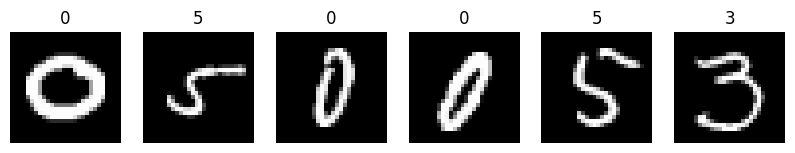

In [2]:


# Załaduj zbiór MNIST (train/test) i pokaż kilka przykładów

root = "./data"
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
print(f"Liczba obrazów w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba obrazów w zbiorze testowym: {len(test_dataset)}")

# pokaż pierwsze 6 obrazów z treningowego loadera
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze().numpy(), cmap="gray")
    axes[i].set_title(int(labels[i]))
    axes[i].axis("off")
plt.show()

In [3]:
import torch

class SimpleNN(torch.nn.Module):
    def __init__(self, input_size: int = 28*28, num_classes: int = 10):
        super().__init__()
        self.fc = torch.nn.Linear(input_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Akceptuje zflattenowane wejście (batch, input_size) lub obraz (batch, C, H, W)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

In [4]:
class ConvNN(torch.nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # po dwóch warstwach conv i dwóch poolingach z 28x28 -> 7x7, kanały 64
        self.fc2 = torch.nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Oczekuje wejścia obrazu (batch, C, H, W)
        # Jeśli przyjdzie zflattenowane, spróbuj przywrócić (N, 1, 28, 28)
        if x.dim() == 2:
            x = x.view(x.size(0), 1, 28, 28)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc2(x)
        return logits

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Sanity check jednego batcha
images_batch, labels_batch = next(iter(train_loader))
images_batch = images_batch.to(device)
labels_batch = labels_batch.to(device)
if isinstance(model, SimpleNN):
    x_batch = images_batch.view(images_batch.size(0), -1)
else:
    x_batch = images_batch
logits_batch = model(x_batch)
loss_batch = criterion(logits_batch, labels_batch)
print(f"Sanity check - batch loss: {loss_batch.item():.4f}; logits shape: {logits_batch.shape}")

Sanity check - batch loss: 2.3073; logits shape: torch.Size([64, 10])


In [ ]:
# Trening modelu na zbiorze train_loader
epochs = 10

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for imgs, labs in train_loader:
        imgs = imgs.to(device)
        labs = labs.to(device)

        # Dla SimpleNN spłaszczamy, dla ConvNN zostawiamy obraz
        if isinstance(model, SimpleNN):
            x = imgs.view(imgs.size(0), -1)
        else:
            x = imgs

        logits = model(x)
        loss = criterion(logits, labs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == labs).sum().item()
        running_total += imgs.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Train acc: {epoch_acc:.4f}")

# Ewaluacja na zbiorze testowym
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        labs = labs.to(device)
        if isinstance(model, SimpleNN):
            x = imgs.view(imgs.size(0), -1)
        else:
            x = imgs
        logits = model(x)
        preds = logits.argmax(dim=1)
        test_correct += (preds == labs).sum().item()
        test_total += imgs.size(0)

print(f"Test accuracy: {test_correct / test_total:.4f}")

# Zapisz model z nazwą zależną od typu
# model_filename = "simple_nn_mnist.pth" if isinstance(model, SimpleNN) else "conv_nn_mnist.pth"
# torch.save(model.state_dict(), model_filename)
# print(f"Model zapisany do {model_filename}")

Epoch 1/10 - Loss: 2.1017 - Train acc: 0.5458
